## LAB CHALLENGE: Neural Matrix Factorization 
In the previous lecture we have built a recommender system using the Neural Matrix Factorization framework. This framework allowed us to combine the GMF layers with the MLP layers in this way:
$$\phi^{GMF} = \mathbf{p_u}^G\odot \mathbf{q_i}^G$$
$$\phi^{MLP} = a_L(\mathbf{W}_L^T(a_{L-1}(...a_2 (\mathbf{W}_2^T \begin{bmatrix}
\mathbf{p_u} \\ \mathbf{q_i}
\end{bmatrix} + \mathbf{b}_2)...)) + \mathbf{b}_L)$$

$$ y_{ui} = \sigma(\mathbf{h}^T \begin{bmatrix}
\ \phi^{GMF} \\ \phi^{MLP}
\end{bmatrix})$$

<center>  <img src="https://drive.google.com/uc?export=view&id=1gNLUpiQdbDPMdvfZYVs3lcou3cd4Favb" width="550" height="400"> </center> 

Let's now try to apply transfer learning to such an architecture. 

- TASK 1: Train the GMF and MLP models separately, inspect and save the parameters.
- TASK 2: Use the pre-trained parameters for initializing the NMF architecture. In particular, use the pre-trained embeddings for users and items and the initialized layers of GMF and MLP.
- TASK 3: Finally, train the NMF model both by freezing the layers preceding the NeuMF layer and by keeping all the parameters trainable. Compare the performance with the network trained from scratch.


In [13]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from metrics import metrics
from NCF_Data import NCF_Data
from neumf import NeuMF

## PATH definition

In [2]:
DATA_PATH = "./ml-100k/u.data" 
MODEL_PATH = "./models/" 

## Parameters Definition

In [3]:
args = {
    "seed": 42,
    "lr": 0.01,
    "dropout": 0.2,
    "batch_size": 256,
    "epochs": 30,
    "top_k": 10,
    "num_factors": 32,
    "layers": (64, 32, 16, 8),
    "out": True,
    "num_ng": 4,
    "num_ng_test": 100
}

In [4]:
best_config = {
    "lr": 0.01,
    "batch_size": 128,
    "num_factors_gmf": 16,
    "num_factors_mlp": 64,
    "epochs": 30,
    "out": True,
    "dropout": (0, 0, 0, 0),
}

In [5]:
np.random.seed(args["seed"])
torch.manual_seed(args["seed"])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cpu')

## Load Train and Test loaders

In [6]:
# load data
ml_100k = pd.read_csv(
    DATA_PATH, sep="\t", names=["user_id", "item_id", "rating", "timestamp"]
)

# set the num_users, items
num_users = ml_100k["user_id"].nunique() + 1
num_items = ml_100k["item_id"].nunique() + 1

# construct the train and test datasets
data = NCF_Data(ml_100k, args)
train_loader = data.get_train_instance()
test_loader = data.get_test_instance()


In [59]:
# ml_100k = pd.read_csv(
#     DATA_PATH, sep="\t", names=["user_id", "item_id", "rating", "timestamp"]
# )
cp = ml_100k.copy(deep=True)
cp["rating"] = 1.0
interact_status = (
    cp.groupby("user_id")["item_id"]
    .apply(set)
    .reset_index()
    .rename(columns={"item_id": "interacted_items"})
)
interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: set(cp["item_id"]) - x)
interact_status

,user_id,interacted_items,negative_items
0,1,"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{273, 274, 275, 276, 277, 278, 279, 280, 281, ..."
1,2,"{257, 258, 1, 10, 13, 14, 269, 272, 273, 274, ...","{2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 15, 16, 17, 1..."
2,3,"{258, 260, 264, 268, 271, 272, 288, 294, 299, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,4,"{258, 260, 264, 11, 271, 288, 294, 300, 301, 3...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15..."
4,5,"{1, 2, 17, 21, 24, 25, 29, 40, 42, 50, 62, 63,...","{3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ..."
...,...,...,...
938,939,"{257, 258, 255, 1028, 9, 266, 15, 274, 275, 40...","{1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 1..."
939,940,"{4, 516, 7, 8, 9, 521, 12, 14, 527, 529, 549, ...","{1, 2, 3, 5, 6, 10, 11, 13, 15, 16, 17, 18, 19..."
940,941,"{257, 258, 1, 7, 15, 273, 147, 919, 408, 294, ...","{2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, ..."
941,942,"{514, 1028, 520, 528, 1050, 539, 31, 50, 71, 5...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [57]:
set(cp["item_id"].unique())


{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

# Models

In [24]:
def train_model(model: nn.Module, train_loader: DataLoader, test_loader: DataLoader):
    model = model.to(device)

    # Loss and optimizer
    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=args["lr"])
    # optimizer = optim.SGD(model.parameters(), lr=args["lr"])

    best_hr = 0

    # Train cycle
    for epoch in range(args["epochs"]):
        start_time = time.time()

        # Train step
        model.train()

        for user, item, label in train_loader:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)

            # Zero grad
            optimizer.zero_grad()

            # Prediction
            prediction = model(user, item)
            loss = loss_function(prediction, label)

            # Backpropagation
            loss.backward()
            optimizer.step()

        # Eval metrics
        model.eval()
        hr, ndcg = metrics(model, test_loader, args["top_k"], device)

        # Print metrics and time elapsed
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch:03d} time to train: {elapsed_time}")
        print(f"HR: {np.mean(hr):.3f}\tNDCG: {np.mean(ndcg):.3f}")

        # If best model, save it
        if hr > best_hr:
            best_hr = hr
            if args["out"]:
                if not os.path.exists(MODEL_PATH):
                    os.mkdir(MODEL_PATH)
                torch.save(
                    model,
                    f"{MODEL_PATH}{model.__class__.__name__}{model.num_factors}.pt"
                )


## GMF model

In [8]:
class GMF(nn.Module):
    def __init__(self, num_users, num_items):
        super(GMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = args["num_factors"]

        self.embedding_user = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.num_factors
        )
        self.embedding_item = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.num_factors
        )

        self.affine_output = nn.Linear(in_features=self.num_factors, out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        logits = self.affine_output(element_product)
        rating = self.logistic(logits)
        return rating.squeeze()


In [9]:
#gmf_model = GMF(num_users, num_items)
#train_model(gmf_model, train_loader, test_loader)
gmf_model = torch.load(MODEL_PATH + "GMF8.pt", map_location=device)

## MLP model

In [10]:
class MLP(nn.Module):
    def __init__(self, num_users, num_items):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = args["num_factors"]

        self.embedding_user = nn.Embedding(
            num_embeddings=num_users, embedding_dim=args["num_factors"]
        )
        self.embedding_item = nn.Embedding(
            num_embeddings=num_items, embedding_dim=args["num_factors"]
        )

        layer_sizes = args["layers"]
        layers = []
        layers.append(nn.Linear(args["num_factors"] * 2, layer_sizes[0]))
        #layers.append(nn.ReLU())
        for in_size, out_size in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.ReLU())
        self.mlp_fc = nn.Sequential(*layers)
        self.mlp_fc.add_module("affine", nn.Linear(layer_sizes[-1], 1))
        self.mlp_fc.add_module("logit", nn.Sigmoid())

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)
        rating = self.mlp_fc(vector)
        return rating.squeeze()


In [11]:
"""args["lr"] = 0.01
args["dropout"] = 0
args["num_factors"] = 64
args['layers'] = [32, 16, 8]
mlp_model = MLP(num_users, num_items)
train_model(mlp_model, train_loader, test_loader)"""
mlp_model = torch.load(MODEL_PATH + "MLP64.pt", map_location=device)

## NeuMF model

In [14]:
#nmf_model = torch.load(MODEL_PATH + "Assignment 1 - best.pt", map_location=device)
nmf_model = NeuMF(gmf_model.num_factors, mlp_model.num_factors, num_users, num_items)

# Defining functions that load sub_models weights

In [15]:
def load_gmf_weights(nmf_model, gmf_model, requires_grad=False):
    nmf_layers_names = [name for name, param in nmf_model.named_parameters()]
    gmf_layers_names = [name for name, param in gmf_model.named_parameters()]
    #create a dict that has as key the value of the layer in the NMF model and as value the layer in the GMF model
    layers_name_match_dict = {k: v for k, v in zip(nmf_layers_names[:2], gmf_layers_names)}
    for nmf_layer_name, gmf_layer_name in layers_name_match_dict.items():
        nmf_model.state_dict()[nmf_layer_name].copy_(gmf_model.state_dict()[gmf_layer_name])
    #deactivate grad for the layers that comes from the GMF model
    for name, param in nmf_model.named_parameters():
        if name in layers_name_match_dict.keys():
            param.requires_grad = requires_grad


def load_mlp_weights(nmf_model, mlp_model, requires_grad=False):
    nmf_layers_names = [name for name, param in nmf_model.named_parameters()]
    mlp_layers_names = [name for name, param in mlp_model.named_parameters()]
    #create a dict that has as key the value of the layer in the NMF model and as value the layer in the MLP model
    layers_name_match_dict = {k: v for k, v in zip(nmf_layers_names[4:], mlp_layers_names[:-2])}
    for nmf_layer_name, mlp_layer_name in layers_name_match_dict.items():
        nmf_model.state_dict()[nmf_layer_name].copy_(mlp_model.state_dict()[mlp_layer_name])
    #deactivate grad for the layers that comes from the MLP model
    for name, param in nmf_model.named_parameters():
        if name in layers_name_match_dict.keys():
            param.requires_grad = requires_grad


def load_pre_trained_weights(nmf_model, gmf_model, mlp_model, requires_grad = False):
    load_gmf_weights(nmf_model, gmf_model, requires_grad)
    load_mlp_weights(nmf_model, mlp_model, requires_grad)

# Performance with sum_models layers freezed

In [16]:
nmf_model = NeuMF(gmf_model.num_factors, mlp_model.num_factors, num_users, num_items)

In [17]:
list(nmf_model.named_parameters())[0][1]

Parameter containing:
tensor([[ 0.4653, -0.4930,  0.6697,  ..., -0.9396,  1.3414,  0.7344],
        [-0.0364, -1.8768, -0.5430,  ...,  0.8550,  0.5962, -0.5022],
        [ 0.8571, -0.4907,  0.1748,  ..., -2.0932, -1.8830,  0.3399],
        ...,
        [-0.9732, -1.2097,  0.1971,  ...,  0.0726, -0.9249,  0.1704],
        [ 1.3458, -2.2545,  0.1308,  ..., -1.6214,  0.7462,  0.1759],
        [-0.1957,  0.3733, -1.3767,  ...,  0.5236,  1.3268, -0.2997]],
       requires_grad=True)

In [18]:
load_pre_trained_weights(nmf_model, gmf_model, mlp_model, requires_grad=False)

In [19]:
list(nmf_model.named_parameters())[0][1]


Parameter containing:
tensor([[-0.1514,  0.4690,  0.6961,  ...,  0.8707, -0.4645, -0.1457],
        [ 0.2311,  0.8680, -0.6166,  ...,  1.5733, -0.4352,  0.3049],
        [-0.1804,  1.0708,  0.9530,  ...,  0.9818,  1.4919,  0.7378],
        ...,
        [-2.6230,  0.1944, -0.3794,  ..., -0.5907, -0.1775, -0.0250],
        [-0.3618,  1.9552,  0.1007,  ...,  0.6635, -0.0256, -1.0146],
        [-0.4400,  2.0753, -0.6651,  ..., -0.6961,  0.1153,  1.3355]])

In [20]:
for name, param in nmf_model.named_parameters():
    print(name, param.requires_grad)

gmf_user_embed.0.weight False
gmf_item_embed.0.weight False
gmf_affine.weight True
gmf_affine.bias True
mlp_user_embed.0.weight False
mlp_item_embed.0.weight False
mlp_fc.0.weight False
mlp_fc.0.bias False
mlp_fc.3.weight False
mlp_fc.3.bias False
mlp_fc.6.weight False
mlp_fc.6.bias False
mlp_fc.9.weight False
mlp_fc.9.bias False
mixing_layers.0.weight True
mixing_layers.0.bias True
mixing_layers.3.weight True
mixing_layers.3.bias True
mixing_layers.6.weight True
mixing_layers.6.bias True


In [21]:
args["lr"]

0.01

In [26]:
train_model(nmf_model, train_loader, test_loader)

Epoch 000 time to train: 40.60856246948242
HR: 0.108	NDCG: 0.045
Epoch 001 time to train: 45.61992788314819
HR: 0.102	NDCG: 0.046
Epoch 002 time to train: 37.16011095046997
HR: 0.098	NDCG: 0.041
Epoch 003 time to train: 36.151079177856445
HR: 0.089	NDCG: 0.038
Epoch 004 time to train: 36.515183448791504
HR: 0.099	NDCG: 0.045
Epoch 005 time to train: 35.918678522109985
HR: 0.104	NDCG: 0.045
Epoch 006 time to train: 40.13951563835144
HR: 0.099	NDCG: 0.044
Epoch 007 time to train: 39.07959175109863
HR: 0.102	NDCG: 0.044
Epoch 008 time to train: 35.99796986579895
HR: 0.107	NDCG: 0.047
Epoch 009 time to train: 37.08579397201538
HR: 0.097	NDCG: 0.041
Epoch 010 time to train: 34.22171425819397
HR: 0.111	NDCG: 0.048
Epoch 011 time to train: 36.0052809715271
HR: 0.104	NDCG: 0.047
Epoch 012 time to train: 34.38989281654358
HR: 0.095	NDCG: 0.043
Epoch 013 time to train: 33.34105920791626
HR: 0.100	NDCG: 0.043
Epoch 014 time to train: 33.93553686141968
HR: 0.094	NDCG: 0.043
Epoch 015 time to train

# Performance letting initialized layers free

In [27]:
nmf_model = NeuMF(gmf_model.num_factors, mlp_model.num_factors, num_users, num_items)
load_pre_trained_weights(nmf_model, gmf_model, mlp_model, requires_grad=True)
for name, param in nmf_model.named_parameters():
    print(name, param.requires_grad)

gmf_user_embed.0.weight True
gmf_item_embed.0.weight True
gmf_affine.weight True
gmf_affine.bias True
mlp_user_embed.0.weight True
mlp_item_embed.0.weight True
mlp_fc.0.weight True
mlp_fc.0.bias True
mlp_fc.3.weight True
mlp_fc.3.bias True
mlp_fc.6.weight True
mlp_fc.6.bias True
mlp_fc.9.weight True
mlp_fc.9.bias True
mixing_layers.0.weight True
mixing_layers.0.bias True
mixing_layers.3.weight True
mixing_layers.3.bias True
mixing_layers.6.weight True
mixing_layers.6.bias True


In [28]:
train_model(nmf_model, train_loader, test_loader)

Epoch 000 time to train: 40.07859539985657
HR: 0.955	NDCG: 0.955
Epoch 001 time to train: 38.10337686538696
HR: 0.988	NDCG: 0.988
Epoch 002 time to train: 38.809794664382935
HR: 0.985	NDCG: 0.985
Epoch 003 time to train: 38.762298345565796
HR: 0.992	NDCG: 0.992
Epoch 004 time to train: 39.592591285705566
HR: 0.992	NDCG: 0.992
Epoch 005 time to train: 40.27716779708862
HR: 0.989	NDCG: 0.989


KeyboardInterrupt: 

# Performance comparison

In [30]:
nmf_freezed = torch.load(MODEL_PATH + "NeuMF64-freezed.pt", map_location = device)
gmf_best = torch.load(MODEL_PATH + "GMF8.pt", map_location = device)
mlp_best = torch.load(MODEL_PATH + "MLP64.pt", map_location = device)
nmf_free = torch.load(MODEL_PATH + "NeuMF64-free.pt", map_location = device)
nmf_init = torch.load(MODEL_PATH + "NeuMF64.pt", map_location = device)

nmf_freezed.to(device) 
gmf_best.to(device) 
mlp_best.to(device)
nmf_free.to(device) 
nmf_init.to(device)

hr, NDCG = {}, {}
hr['NeuMF - freezed'], NDCG['NeuMF - freezed'] = metrics(nmf_freezed, test_loader, 10, device)
hr['NeuMF - free'], NDCG['NeuMF - free'] = metrics(nmf_free, test_loader, 10, device)
hr['NeuMF - init'], NDCG['NeuMF - init'] = metrics(nmf_init, test_loader, 10, device)
hr['GMF'], NDCG['GMF'] = metrics(gmf_best, test_loader, 10, device)
hr['MLP'], NDCG['MLP'] = metrics(mlp_best, test_loader, 10, device)

Text(0.5, 1.0, 'Best NDCG across models')

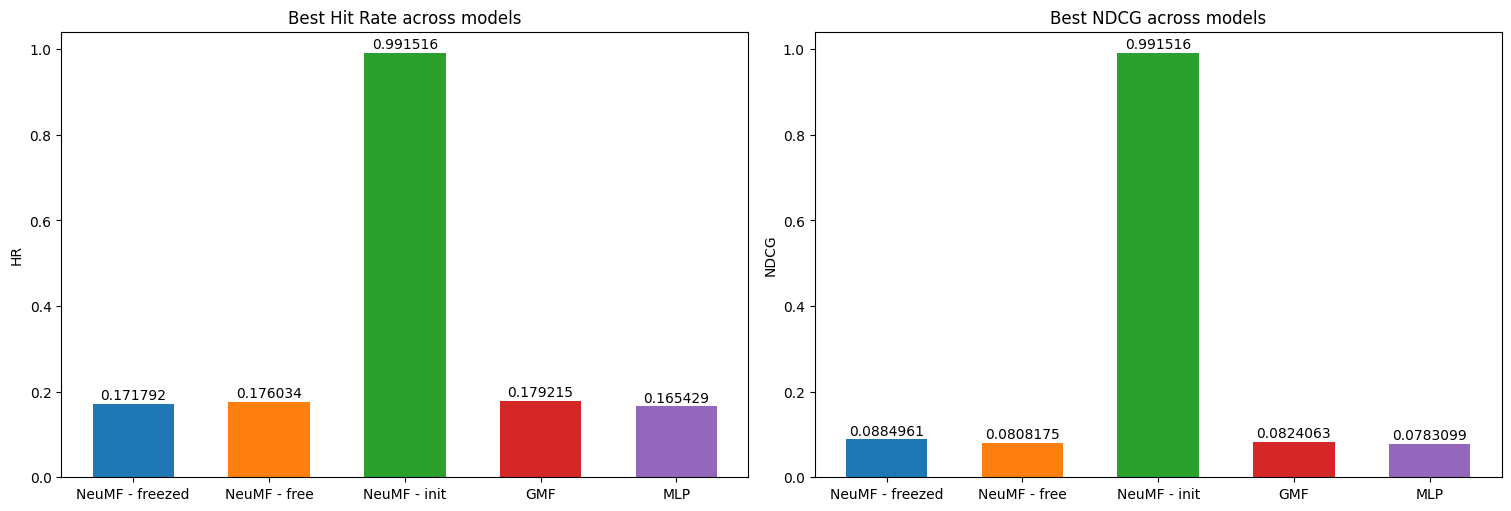

In [32]:
fig, ax = plt.subplots(1, 2, layout = "constrained", figsize = (15, 5))
for model, value in hr.items():
    rect = ax[0].bar(model, value, width= 0.6)
    ax[0].bar_label(rect, padding = 1)

ax[0].set_ylabel("HR")
# ax[0].set_ylim(0.5, 0.68)
ax[0].set_title("Best Hit Rate across models")

for model, value in NDCG.items():
    rect = ax[1].bar(model, value, width= 0.6)
    ax[1].bar_label(rect, padding = 1)

ax[1].set_ylabel("NDCG")
# ax[1].set_ylim(0.3, 0.40)
ax[1].set_title("Best NDCG across models")